In [0]:
import os
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
whiteboardImages_Folder="/content/gdrive/My Drive/allWhiteboardImages/"
whiteboardImages_Paths=os.listdir(whiteboardImages_Folder)
print("Whiteboard images : ",len(whiteboardImages_Paths))
otherImages_Folder="/content/gdrive/My Drive/cocoImages/"
otherImages_Paths=os.listdir(otherImages_Folder)
print("Other images : ",len(otherImages_Paths))

Whiteboard images :  1682
Other images :  2294


In [0]:
print("difference = ",len(otherImages_Paths)-len(whiteboardImages_Paths))

coco_categories =[x.split("_")[0] for x in otherImages_Paths]
coco_categories = list(set([x for x in coco_categories if ".jpg" not in x and "IMG" not in x]))
coco_categories_dict = {x:[] for x in coco_categories}
all_coco_categories_images=[]
for path in otherImages_Paths:
  for c in coco_categories_dict.keys():
    if c in path:
      coco_categories_dict[c].append(path)
      all_coco_categories_images.append(path)

print(coco_categories,len(coco_categories))
reduce_num=(len(otherImages_Paths)-len(whiteboardImages_Paths))/len(coco_categories)
print("difference/num of cat = ",reduce_num)
print("need to reduce ",reduce_num,"images from each category")

non_coco_images=[] #newly added whiteboard images to other folder
for path in otherImages_Paths:
  if path not in all_coco_categories_images:
    non_coco_images.append(path)

print("\ncoco images ",len(all_coco_categories_images))
print("non coco ",len(non_coco_images))
print("total ",len(otherImages_Paths))

new_otherImages_Paths = non_coco_images
for cat in coco_categories_dict.keys():
  n = len(coco_categories_dict[cat])
  for i in range(n-51):
    path = coco_categories_dict[cat][i]
    new_otherImages_Paths.append(path)

print("new total ",len(new_otherImages_Paths))

difference =  612
['indoor', 'electronic', 'appliance', 'kitchen', 'person', 'food', 'sports', 'vehicle', 'furniture', 'animal', 'outdoor', 'accessory'] 12
difference/num of cat =  51.0
need to reduce  51.0 images from each category

coco images  2049
non coco  245
total  2294
new total  1682


In [0]:
otherImages_Paths = new_otherImages_Paths

In [0]:
data = pd.DataFrame()
print(len(data))
whiteboardImagesCount = 0
for imgpath in whiteboardImages_Paths:
  whiteboardImagesCount = whiteboardImagesCount + 1
  img = cv2.imread(whiteboardImages_Folder+ imgpath)
  h,w,_=img.shape
  data=data.append({"path":imgpath,"height":h,"width":w,"label":"Whiteboard"},ignore_index=True)

data=data.reset_index(drop=True)
print(len(data))

otherImagesCount=0
for imgpath in otherImages_Paths:
  if otherImagesCount < whiteboardImagesCount:
    otherImagesCount = otherImagesCount + 1
    img = cv2.imread(otherImages_Folder+ imgpath)
    h,w,_=img.shape
    data=data.append({"path":imgpath,"height":h,"width":w,"label":"Other"},ignore_index=True)
data=data.reset_index(drop=True)
print(len(data))

data.to_csv('new_labelled_data.csv')
!cp new_labelled_data.csv "/content/gdrive/My Drive/"

0


KeyboardInterrupt: ignored

In [0]:
df = pd.read_csv("/content/gdrive/My Drive/new_labelled_data.csv",usecols=["path","height","width","label"])
# df = df.drop(2963).reset_index(drop=True)
print(len(df))
print(df["label"].value_counts())
df.head()

3364
Whiteboard    1682
Other         1682
Name: label, dtype: int64


,height,label,path,width
0,482.0,Whiteboard,00_27_37_00005.png,656.0
1,578.0,Whiteboard,00_17_40_00003.png,787.0
2,738.0,Whiteboard,00_21_04_00004.png,1280.0
3,768.0,Whiteboard,2f08af5c772f6f23.jpg,1024.0
4,682.0,Whiteboard,d4f8d3b3cdee5065.jpg,1024.0


In [0]:
df = pd.read_csv("/content/gdrive/My Drive/features.csv")
print(df.shape)
df.head()

(4022, 164)


,height,label,path,width,totalNumberOfPixels,completeWhitePixelCount,completeNonWhitePixelCount,ratio_CompleteWhite_To_Total,ratio_CompleteNoneWhite_To_Total,ratio_CompleteNoneWhite_To_CompleteWhite,completeWhitePixelCount_AfterImageResize,completeNonWhitePixelCount_AfterImageResize,ratio_CompleteWhite_To_Total_AfterImageResize,ratio_CompleteNoneWhite_To_Total_AfterImageResize,ratio_CompleteNoneWhite_To_CompleteWhite_AfterImageResize,partialWhitePixelCount,partialNonWhitePixelCount,ratio_PartialWhite_To_Total,ratio_PartialNoneWhite_To_Total,ratio_PartialNoneWhite_To_PartialWhite,partialWhitePixelCount_AfterImageResize,partialNonWhitePixelCount_AfterImageResize,ratio_PartialWhite_To_Total_AfterImageResize,ratio_PartialNoneWhite_To_Total_AfterImageResize,ratio_PartialNoneWhite_To_PartialWhite_AfterImageResize,PixelCountInRange_205_210,PixelCountInRange_210_215,PixelCountInRange_215_220,PixelCountInRange_220_225,PixelCountInRange_225_230,PixelCountInRange_230_235,PixelCountInRange_235_240,PixelCountInRange_240_245,PixelCountInRange_245_250,PixelCountInRange_250_255,PixelCountInRange_205_210_AfterImageResize,PixelCountInRange_210_215_AfterImageResize,PixelCountInRange_215_220_AfterImageResize,PixelCountInRange_220_225_AfterImageResize,PixelCountInRange_225_230_AfterImageResize,...,9Grids_partialNonWhitePixelCount_Segment_3,9Grids_ratio_PartialWhite_To_Total_Segment_3,9Grids_ratio_PartialNoneWhite_To_Total_Segment_3,9Grids_ratio_PartialNoneWhite_To_PartialWhite_Segment_3,9Grids_partialWhitePixelCount_Segment_4,9Grids_partialNonWhitePixelCount_Segment_4,9Grids_ratio_PartialWhite_To_Total_Segment_4,9Grids_ratio_PartialNoneWhite_To_Total_Segment_4,9Grids_ratio_PartialNoneWhite_To_PartialWhite_Segment_4,9Grids_partialWhitePixelCount_Segment_5,9Grids_partialNonWhitePixelCount_Segment_5,9Grids_ratio_PartialWhite_To_Total_Segment_5,9Grids_ratio_PartialNoneWhite_To_Total_Segment_5,9Grids_ratio_PartialNoneWhite_To_PartialWhite_Segment_5,9Grids_partialWhitePixelCount_Segment_6,9Grids_partialNonWhitePixelCount_Segment_6,9Grids_ratio_PartialWhite_To_Total_Segment_6,9Grids_ratio_PartialNoneWhite_To_Total_Segment_6,9Grids_ratio_PartialNoneWhite_To_PartialWhite_Segment_6,9Grids_partialWhitePixelCount_Segment_7,9Grids_partialNonWhitePixelCount_Segment_7,9Grids_ratio_PartialWhite_To_Total_Segment_7,9Grids_ratio_PartialNoneWhite_To_Total_Segment_7,9Grids_ratio_PartialNoneWhite_To_PartialWhite_Segment_7,9Grids_partialWhitePixelCount_Segment_8,9Grids_partialNonWhitePixelCount_Segment_8,9Grids_ratio_PartialWhite_To_Total_Segment_8,9Grids_ratio_PartialNoneWhite_To_Total_Segment_8,9Grids_ratio_PartialNoneWhite_To_PartialWhite_Segment_8,label_num,9Grids_HotspotPixelCount_Segment_0,9Grids_HotspotPixelCount_Segment_1,9Grids_HotspotPixelCount_Segment_2,9Grids_HotspotPixelCount_Segment_3,9Grids_HotspotPixelCount_Segment_4,9Grids_HotspotPixelCount_Segment_5,9Grids_HotspotPixelCount_Segment_6,9Grids_HotspotPixelCount_Segment_7,9Grids_HotspotPixelCount_Segment_8,RecognizedTextLength
0,680.0,Whiteboard,1e129c1974567802.jpg,1024.0,696320.0,0.0,696320.0,0.000000,1.000000,0.000000,0.0,422500.0,0.000000,0.606761,0.000000,948.0,695372.0,0.001361,0.998639,733.514768,773.0,421727.0,0.001110,0.605651,545.571798,513,814,1187,1662,946,87,38,1,0,1,353,524,768,1167,576,...,46636.0,0.000429,0.999571,2331.800000,0.0,46656.0,0.000000,1.000000,0.000000,0.0,46656.0,0.000000,1.000000,0.000000,0.0,46656.0,0.000000,1.000000,0.000000,0.0,46656.0,0.000000,1.000000,0.000000,0.0,46656.0,0.000000,1.000000,0.000000,1,0.395876,0.395876,0.395876,0.395876,0.395876,0.171382,0.171382,0.171382,0.171382,0
1,762.0,Whiteboard,03f4034e5290b149.jpg,1024.0,780288.0,0.0,780288.0,0.000000,1.000000,0.000000,0.0,422500.0,0.000000,0.541467,0.000000,0.0,780288.0,0.000000,1.000000,0.000000,0.0,422500.0,0.000000,0.541467,0.000000,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,46656.0,0.000000,1.000000,0.000000,0.0,46656.0,0.000000,1.000000,0.000000,0.0,46656.0,0.000000,1.000000,0.000000,0.0,46656.0,0.000000,1.000000,0.00

In [0]:
def openImage(row):
  if row["label"]=="Whiteboard":
    return cv2.imread(whiteboardImages_Folder+row["path"])
  return cv2.imread(otherImages_Folder+row["path"])

def writeDf(df,filename):
  df.to_csv(filename, encoding='utf-8', index=False)
  !cp $filename "/content/gdrive/My Drive/"

IMG_SIZE = 650


In [0]:
def completeWhiteAndNonWhitePixelCount(image, resize = False):
  if image is None:
    return [0,0,0,0,0]
  total = image.shape[0]*image.shape[1]
  image_pil = Image.fromarray(image)
  if(resize):
    image_pil = image_pil.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
  white = 0
  other=0
  for pixel in image_pil.getdata():
    if pixel == (255, 255, 255): 
      white += 1
    else:
      other+=1
  other_by_white = 0 if white==0 else other/white
  return  [white,other,white/total,other/total,other_by_white]

In [0]:
df["totalNumberOfPixels"] = df.apply(lambda row : row["height"]*row["width"]  , axis = 1 )
print(df.shape)
columns = ['completeWhitePixelCount','completeNonWhitePixelCount',"ratio_CompleteWhite_To_Total","ratio_CompleteNoneWhite_To_Total","ratio_CompleteNoneWhite_To_CompleteWhite"]
df[columns] = df.apply(lambda x: completeWhiteAndNonWhitePixelCount(openImage(x)), axis=1, result_type='expand')
print(df.shape)

writeDf(df,"features_new.csv")
df.head()

(3364, 5)
(3364, 10)
(3364, 15)


,height,label,path,width,totalNumberOfPixels,completeWhitePixelCount,completeNonWhitePixelCount,ratio_CompleteWhite_To_Total,ratio_CompleteNoneWhite_To_Total,ratio_CompleteNoneWhite_To_CompleteWhite,completeWhitePixelCount_AfterImageResize,completeNonWhitePixelCount_AfterImageResize,ratio_CompleteWhite_To_Total_AfterImageResize,ratio_CompleteNoneWhite_To_Total_AfterImageResize,ratio_CompleteNoneWhite_To_CompleteWhite_AfterImageResize
0,482.0,Whiteboard,00_27_37_00005.png,656.0,316192.0,3119.0,313073.0,0.009864,0.990136,100.376082,4310.0,418190.0,0.013631,1.322582,97.027842
1,578.0,Whiteboard,00_17_40_00003.png,787.0,454886.0,0.0,454886.0,0.000000,1.000000,0.000000,0.0,422500.0,0.000000,0.928804,0.000000
2,738.0,Whiteboard,00_21_04_00004.png,1280.0,944640.0,345.0,944295.0,0.000365,0.999635,2737.086957,355.0,422145.0,0.000376,0.446885,1189.140845
3,768.0,Whiteboard,2f08af5c772f6f23.jpg,1024.0,786432.0,1.0,786431.0,0.000001,0.999999,786431.000000,0.0,422500.0,0.000000,0.537237,0.000000
4,682.0,Whiteboard,d4f8d3b3cdee5065.jpg,1024.0,698368.0,405.0,697963.0,0.000580,0.999420,1723.365432,468.0,422032.0,0.000670,0.604312,901.777778


In [20]:
columns = ['completeWhitePixelCount','completeNonWhitePixelCount',"ratio_CompleteWhite_To_Total","ratio_CompleteNoneWhite_To_Total","ratio_CompleteNoneWhite_To_CompleteWhite"]
columns = [c+"_AfterImageResize" for c in columns]
df[columns] = df.apply(lambda x: completeWhiteAndNonWhitePixelCount(openImage(x), resize = True), axis=1, result_type='expand')
print(df.shape)

writeDf(df,"features_afterResizeOnly.csv")
df.head()

(3364, 14)


,height,label,path,width,partialWhitePixelCount_AfterImageResize,partialNonWhitePixelCount_AfterImageResize,ratio_PartialWhite_To_Total_AfterImageResize,ratio_PartialNoneWhite_To_Total_AfterImageResize,ratio_PartialNoneWhite_To_PartialWhite_AfterImageResize,completeWhitePixelCount_AfterImageResize,completeNonWhitePixelCount_AfterImageResize,ratio_CompleteWhite_To_Total_AfterImageResize,ratio_CompleteNoneWhite_To_Total_AfterImageResize,ratio_CompleteNoneWhite_To_CompleteWhite_AfterImageResize
0,482.0,Whiteboard,00_27_37_00005.png,656.0,335091.0,87409.0,1.059771,0.276443,0.260852,4310.0,418190.0,0.013631,1.322582,97.027842
1,578.0,Whiteboard,00_17_40_00003.png,787.0,278469.0,144031.0,0.612173,0.316631,0.517225,0.0,422500.0,0.000000,0.928804,0.000000
2,738.0,Whiteboard,00_21_04_00004.png,1280.0,301697.0,120803.0,0.319378,0.127883,0.400412,355.0,422145.0,0.000376,0.446885,1189.140845
3,768.0,Whiteboard,2f08af5c772f6f23.jpg,1024.0,40.0,422460.0,0.000051,0.537186,10561.500000,0.0,422500.0,0.000000,0.537237,0.000000
4,682.0,Whiteboard,d4f8d3b3cdee5065.jpg,1024.0,78656.0,343844.0,0.112628,0.492354,4.371491,468.0,422032.0,0.000670,0.604312,901.777778


In [0]:
def partialWhiteAndNonWhitePixelCount(image, resize = False):
  if image is None:
    return [0,0,0,0,0]
  total = image.shape[0]*image.shape[1]
  image_pil = Image.fromarray(image)
  if(resize):
    image_pil = image_pil.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
  white = 0
  other=0
  for pixel in image_pil.getdata():
    if pixel[0]>230 and pixel[1]>230 and pixel[2]>230: 
      white += 1
    else:
      other+=1
  other_by_white = 0 if white==0 else other/white
  return  [white,other,white/total,other/total,other_by_white]

In [0]:
print(df.shape)
columns= ['partialWhitePixelCount','partialNonWhitePixelCount',"ratio_PartialWhite_To_Total","ratio_PartialNoneWhite_To_Total","ratio_PartialNoneWhite_To_PartialWhite"]
df[columns] = df.apply(lambda x: partialWhiteAndNonWhitePixelCount(openImage(x)), axis=1, result_type='expand')
print(df.shape)

writeDf(df,"features_new.csv")
df.head()

(3364, 15)


In [19]:
columns= ['partialWhitePixelCount','partialNonWhitePixelCount',"ratio_PartialWhite_To_Total","ratio_PartialNoneWhite_To_Total","ratio_PartialNoneWhite_To_PartialWhite"]
columns = [c+"_AfterImageResize" for c in columns]
df[columns] = df.apply(lambda x: partialWhiteAndNonWhitePixelCount(openImage(x), resize=True), axis=1, result_type='expand')
print(df.shape)

writeDf(df,"features_afterResizeOnly.csv")
df.head()

(3364, 9)


,height,label,path,width,partialWhitePixelCount_AfterImageResize,partialNonWhitePixelCount_AfterImageResize,ratio_PartialWhite_To_Total_AfterImageResize,ratio_PartialNoneWhite_To_Total_AfterImageResize,ratio_PartialNoneWhite_To_PartialWhite_AfterImageResize
0,482.0,Whiteboard,00_27_37_00005.png,656.0,335091.0,87409.0,1.059771,0.276443,0.260852
1,578.0,Whiteboard,00_17_40_00003.png,787.0,278469.0,144031.0,0.612173,0.316631,0.517225
2,738.0,Whiteboard,00_21_04_00004.png,1280.0,301697.0,120803.0,0.319378,0.127883,0.400412
3,768.0,Whiteboard,2f08af5c772f6f23.jpg,1024.0,40.0,422460.0,0.000051,0.537186,10561.500000
4,682.0,Whiteboard,d4f8d3b3cdee5065.jpg,1024.0,78656.0,343844.0,0.112628,0.492354,4.371491


In [0]:
def getBucketIndex(start,end,bucket_size,pixel_val):
  if pixel_val == 255:
    pixel_val = 254
  return int( (pixel_val-start)/bucket_size )

def getPixelCountInBuckets(start,end,bucket_size,image, resize = False):
  counts = [ 0 for i in range(int((end-start)/bucket_size))]
  #print(counts)
  image_pil = Image.fromarray(image)
  if(resize):
    image_pil = image_pil.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
  for pixel in image_pil.getdata():
    a,b,c=pixel[0],pixel[1],pixel[2]
    if a>=start and b>=start and c>=start:
      #print("more than threshold")
      a_index = getBucketIndex(start,end,bucket_size,a)
      b_index = getBucketIndex(start,end,bucket_size,b)
      c_index = getBucketIndex(start,end,bucket_size,c)
      if a_index == b_index and a_index == c_index:
        counts[a_index]+=1
  return counts



In [0]:
print(df.shape)
start = 205
end = 255
bucket_size = 5
columns= ["PixelCountInRange_"+str(i)+"_"+str(i+bucket_size) for i in range(start,end,bucket_size)]
df[columns] = df.apply(lambda x: getPixelCountInBuckets(start,end,bucket_size,openImage(x)), axis=1, result_type='expand')
print(df.shape)
writeDf(df,"features_new.csv")
df.head()

In [22]:
print(df.shape)

start = 205
end = 255
bucket_size = 5
columns= ["PixelCountInRange_"+str(i)+"_"+str(i+bucket_size) for i in range(start,end,bucket_size)]
columns = [c+"_AfterImageResize" for c in columns]
df[columns] = df.apply(lambda x: getPixelCountInBuckets(start,end,bucket_size,openImage(x), resize=True), axis=1, result_type='expand')
print(df.shape)

writeDf(df,"features_afterResizeOnly.csv")
df.head()

(3364, 14)
(3364, 24)


,height,label,path,width,partialWhitePixelCount_AfterImageResize,partialNonWhitePixelCount_AfterImageResize,ratio_PartialWhite_To_Total_AfterImageResize,ratio_PartialNoneWhite_To_Total_AfterImageResize,ratio_PartialNoneWhite_To_PartialWhite_AfterImageResize,completeWhitePixelCount_AfterImageResize,completeNonWhitePixelCount_AfterImageResize,ratio_CompleteWhite_To_Total_AfterImageResize,ratio_CompleteNoneWhite_To_Total_AfterImageResize,ratio_CompleteNoneWhite_To_CompleteWhite_AfterImageResize,PixelCountInRange_205_210_AfterImageResize,PixelCountInRange_210_215_AfterImageResize,PixelCountInRange_215_220_AfterImageResize,PixelCountInRange_220_225_AfterImageResize,PixelCountInRange_225_230_AfterImageResize,PixelCountInRange_230_235_AfterImageResize,PixelCountInRange_235_240_AfterImageResize,PixelCountInRange_240_245_AfterImageResize,PixelCountInRange_245_250_AfterImageResize,PixelCountInRange_250_255_AfterImageResize
0,482.0,Whiteboard,00_27_37_00005.png,656.0,335091.0,87409.0,1.059771,0.276443,0.260852,4310.0,418190.0,0.013631,1.322582,97.027842,694,1322,815,814,1143,1411,4687,7009,4025,311067
1,578.0,Whiteboard,00_17_40_00003.png,787.0,278469.0,144031.0,0.612173,0.316631,0.517225,0.0,422500.0,0.000000,0.928804,0.000000,34,548,121,1264,1175,788,15122,523,15,2
2,738.0,Whiteboard,00_21_04_00004.png,1280.0,301697.0,120803.0,0.319378,0.127883,0.400412,355.0,422145.0,0.000376,0.446885,1189.140845,301,436,633,1150,882,14585,2467,1555,1219,1206
3,768.0,Whiteboard,2f08af5c772f6f23.jpg,1024.0,40.0,422460.0,0.000051,0.537186,10561.500000,0.0,422500.0,0.000000,0.537237,0.000000,2,3,3,3,2,2,0,1,3,5
4,682.0,Whiteboard,d4f8d3b3cdee5065.jpg,1024.0,78656.0,343844.0,0.112628,0.492354,4.371491,468.0,422032.0,0.000670,0.604312,901.777778,6,2,5,7,11,20,54,536,5037,7499


In [0]:
# Bounding box detection 
# Feature extraction

def getRatio(image):
  ret,imageAfterThresholding = cv2.threshold(image,127,255,cv2.THRESH_BINARY)
  image_pil = Image.fromarray(imageAfterThresholding)
  image_pil = image_pil.resize((IMG_SIZE, IMG_SIZE), Image.ANTIALIAS)
  black = 0
  white = 0

  for pixel in image_pil.getdata():
    if pixel == (255, 255, 255): 
        white += 1
    else:
        black += 1
  if not white == 0:
    ratio = black/white
  else:
    ratio = 0
  return ratio

def maskToFindWhitePixels(image):
    ret,imageAfterThresholding = cv2.threshold(image,127,255,cv2.THRESH_BINARY)
    # HSV mask to find white 
    lower_white = np.array([0, 0, 0])
    upper_white = np.array([0, 0, 255])
    
    hsv = cv2.cvtColor(imageAfterThresholding, cv2.COLOR_BGR2HSV)
    # Threshold the HSV image to get only white colors
    mask = cv2.inRange(hsv, lower_white, upper_white)
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(imageAfterThresholding, imageAfterThresholding, mask= mask)
    return res

def getMaxAreaForPossibleWhiteboard(image, image_area):
  res = maskToFindWhitePixels(image)
  edged = cv2.Canny(res, 30, 200) 
  contours,h = cv2.findContours(edged,1,2)
  maxArea = 0;
  for contour in contours:
    area = cv2.contourArea(contour)
    if area > maxArea:
        # cv2.drawContours(image,[contour],0,255,-1)
      maxArea = area;
  # cv2_imshow(image)
  return maxArea, maxArea/image_area;

def getFeatures(image,resize=False):
  if(resize):
    image = cv2.resize(image,(IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_AREA)
  height, width = image.shape[:2]
  image_area = height * width;
  # Feature 1: Other color to white ratio
  blackToWhiteRatio = getRatio(image)
  # print(blackToWhiteRatio)
  # Feature 2: Max area contour
  maxPossibleArea, maxPossibleAreaPercentage = getMaxAreaForPossibleWhiteboard(image, image_area)
  # print(maxPossibleArea)
  # print(maxPossibleAreaPercentage)
  # Feature 3: Number of Hotspots - to identify shine in the image
  hotspotPixels = getHotspots(image)
  # print(hotspotPixels)
  # Feature 4: Possible text area identification
  textareaNumber, textAreaPercentage = getPossibleTextArea(image, image_area)
  # print(textareaNumber)
  # print(textAreaPercentage)
  return [blackToWhiteRatio,maxPossibleArea, maxPossibleAreaPercentage,hotspotPixels,textareaNumber, textAreaPercentage]

def getHotspots(image,resize=False):
  if(resize):
    image =cv2.resize(image,(IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_CUBIC)

  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (11, 11), 0)
  thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)[1]
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=4)
  np_counter = thresh[(thresh == 255)].size
  return np_counter/thresh.size

def getPossibleTextArea(image, image_area):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  
  ret,thresh1 = cv2.threshold(gray, 0, 255,cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
  rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 3))
  dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)
  contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  area = 0
  for c in contours:
    area += cv2.contourArea(c)
  return len(contours), area/image_area

# imagePath = whiteboardImages_Folder + df.loc[df['label'] == 'Whiteboard'].reset_index()['path'].iloc[45]
# getFeatures(imagePath)
# imagePath = otherImages_Folder + df.loc[df['label'] == 'Other'].reset_index()['path'].iloc[0]
# getFeatures(imagePath)




In [0]:
print(df.shape)
columns = ['blackToWhiteAfterImageResize','maxPossibleWhiteboardArea','maxPossibleWhiteboardAreaPercentage',"HotspotPixelsCount","textAreaCount", "textAreaPercentage"]
df[columns] = df.apply(lambda x: getFeatures(openImage(x)), axis=1, result_type='expand')
print(df.shape)
writeDf(df,"features_new.csv")
print(df.shape)

In [25]:
print(df.shape)
columns = ['blackToWhiteRatio','maxPossibleWhiteboardArea','maxPossibleWhiteboardAreaPercentage',"HotspotPixelsCount","textAreaCount", "textAreaPercentage"]
columns = [c+"_AfterImageResize" for c in columns]
df[columns] = df.apply(lambda x: getFeatures(openImage(x),resize=True), axis=1, result_type='expand')

writeDf(df,"features_afterResizeOnly.csv")
print(df.shape)

(3364, 24)
(3364, 30)


In [27]:
def getHotspotsSteps(image,start,stepsize,resize=False):
  if(resize):
    image =cv2.resize(image,(IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_CUBIC)

  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (11, 11), 0)
  minvals = [i for i in range(start,255,stepsize)]
  values=[]
  for minval in minvals:
    thresh = cv2.threshold(blurred, minval, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=4)
    np_counter = thresh[(thresh == 255)].size
    values.append(np_counter/thresh.size)
  return values

start = 200

stepsize = 5

print(df.shape)
columns = ["HotspotPixelsCount_Minval"+str(i) for i in range(start,255,stepsize)]
columns = [c+"_AfterImageResize" for c in columns]
df[columns] =  df.apply(lambda x: getHotspotsSteps(openImage(x),start,stepsize,resize=True), axis=1, result_type='expand')
print(df.shape)
writeDf(df, "features_afterResizeOnly.csv")
df.head()

(3364, 30)
(3364, 41)


,height,label,path,width,partialWhitePixelCount_AfterImageResize,partialNonWhitePixelCount_AfterImageResize,ratio_PartialWhite_To_Total_AfterImageResize,ratio_PartialNoneWhite_To_Total_AfterImageResize,ratio_PartialNoneWhite_To_PartialWhite_AfterImageResize,completeWhitePixelCount_AfterImageResize,completeNonWhitePixelCount_AfterImageResize,ratio_CompleteWhite_To_Total_AfterImageResize,ratio_CompleteNoneWhite_To_Total_AfterImageResize,ratio_CompleteNoneWhite_To_CompleteWhite_AfterImageResize,PixelCountInRange_205_210_AfterImageResize,PixelCountInRange_210_215_AfterImageResize,PixelCountInRange_215_220_AfterImageResize,PixelCountInRange_220_225_AfterImageResize,PixelCountInRange_225_230_AfterImageResize,PixelCountInRange_230_235_AfterImageResize,PixelCountInRange_235_240_AfterImageResize,PixelCountInRange_240_245_AfterImageResize,PixelCountInRange_245_250_AfterImageResize,PixelCountInRange_250_255_AfterImageResize,blackToWhiteRatio_AfterImageResize,maxPossibleWhiteboardArea_AfterImageResize,maxPossibleWhiteboardAreaPercentage_AfterImageResize,HotspotPixelsCount_AfterImageResize,textAreaCount_AfterImageResize,textAreaPercentage_AfterImageResize,HotspotPixelsCount_Minval200_AfterImageResize,HotspotPixelsCount_Minval205_AfterImageResize,HotspotPixelsCount_Minval210_AfterImageResize,HotspotPixelsCount_Minval215_AfterImageResize,HotspotPixelsCount_Minval220_AfterImageResize,HotspotPixelsCount_Minval225_AfterImageResize,HotspotPixelsCount_Minval230_AfterImageResize,HotspotPixelsCount_Minval235_AfterImageResize,HotspotPixelsCount_Minval240_AfterImageResize,HotspotPixelsCount_Minval245_AfterImageResize,HotspotPixelsCount_Minval250_AfterImageResize
0,482.0,Whiteboard,00_27_37_00005.png,656.0,335091.0,87409.0,1.059771,0.276443,0.260852,4310.0,418190.0,0.013631,1.322582,97.027842,694,1322,815,814,1143,1411,4687,7009,4025,311067,0.133112,395831.5,0.936879,0.870308,1.0,0.996925,0.870994,0.863583,0.851243,0.835886,0.823098,0.810213,0.795924,0.776686,0.747475,0.732196,0.688473
1,578.0,Whiteboard,00_17_40_00003.png,787.0,278469.0,144031.0,0.612173,0.316631,0.517225,0.0,422500.0,0.000000,0.928804,0.000000,34,548,121,1264,1175,788,15122,523,15,2,0.271851,342758.0,0.811262,0.765628,1.0,0.996925,0.766665,0.749077,0.738521,0.726499,0.706499,0.693579,0.674885,0.624883,0.000000,0.000000,0.000000
2,738.0,Whiteboard,00_21_04_00004.png,1280.0,301697.0,120803.0,0.319378,0.127883,0.400412,355.0,422145.0,0.000376,0.446885,1189.140845,301,436,633,1150,882,14585,2467,1555,1219,1206,0.129999,98.0,0.000232,0.838350,55.0,0.294153,0.838634,0.804078,0.785467,0.765027,0.741387,0.719617,0.666727,0.000000,0.000000,0.000000,0.000000
3,768.0,Whiteboard,2f08af5c772f6f23.jpg,1024.0,40.0,422460.0,0.000051,0.537186,10561.500000,0.0,422500.0,0.000000,0.537237,0.000000,2,3,3,3,2,2,0,1,3,5,0.808934,1995.5,0.004723,0.000000,28.0,0.609538,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,682.0,Whiteboard,d4f8d3b3cdee5065.jpg,1024.0,78656.0,343844.0,0.112628,0.492354,4.371491,468.0,422032.0,0.000670,0.604312,901.777778,6,2,5,7,11,20,54,536,5037,7499,0.582201,1839.5,0.004354,0.389560,37.0,0.588117,0.390230,0.357633,0.326469,0.298698,0.269200,0.238426,0.205955,0.185749,0.140864,0.088961,0.006433


In [30]:

def splitIntoGrids(image,n):
  image =cv2.resize(image,(IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_CUBIC)
  x=IMG_SIZE//n
  images=[]
  for i in range(n):
    for j in range(n):
      images.append(image[int(j*x):int((j+1)*x),int(i*x):int((i+1)*x)])
  return images

print(df.shape)

n=3
columns = ['completeWhitePixelCount','completeNonWhitePixelCount',"ratio_CompleteWhite_To_Total","ratio_CompleteNoneWhite_To_Total","ratio_CompleteNoneWhite_To_CompleteWhite"]
columns = [c+"_AfterImageResize" for c in columns]
columns = [str(n*n)+"Grids_"+c for c in columns]
print(len(columns),columns)
indices=[str(i) for i in range(n*n)]
complete_segment_columns = [c+"_Segment_"+index for index in indices for c in columns]
df = df.reindex(columns=df.columns.tolist()+complete_segment_columns)
print(len(complete_segment_columns),complete_segment_columns)
print(df.shape)


for i in range(len(df)):
  images=splitIntoGrids(openImage(df.loc[i,:]),n)
  for j in range(len(images)):
    values=completeWhiteAndNonWhitePixelCount(images[j])
    segment_columns = complete_segment_columns[j*5:j*5+5]
    df.loc[i,segment_columns]=values

writeDf(df,"features_afterResizeOnly.csv")
print(df.shape)
df.head()
  

(3364, 41)
5 ['9Grids_completeWhitePixelCount_AfterImageResize', '9Grids_completeNonWhitePixelCount_AfterImageResize', '9Grids_ratio_CompleteWhite_To_Total_AfterImageResize', '9Grids_ratio_CompleteNoneWhite_To_Total_AfterImageResize', '9Grids_ratio_CompleteNoneWhite_To_CompleteWhite_AfterImageResize']
45 ['9Grids_completeWhitePixelCount_AfterImageResize_Segment_0', '9Grids_completeNonWhitePixelCount_AfterImageResize_Segment_0', '9Grids_ratio_CompleteWhite_To_Total_AfterImageResize_Segment_0', '9Grids_ratio_CompleteNoneWhite_To_Total_AfterImageResize_Segment_0', '9Grids_ratio_CompleteNoneWhite_To_CompleteWhite_AfterImageResize_Segment_0', '9Grids_completeWhitePixelCount_AfterImageResize_Segment_1', '9Grids_completeNonWhitePixelCount_AfterImageResize_Segment_1', '9Grids_ratio_CompleteWhite_To_Total_AfterImageResize_Segment_1', '9Grids_ratio_CompleteNoneWhite_To_Total_AfterImageResize_Segment_1', '9Grids_ratio_CompleteNoneWhite_To_CompleteWhite_AfterImageResize_Segment_1', '9Grids_complet

,height,label,path,width,partialWhitePixelCount_AfterImageResize,partialNonWhitePixelCount_AfterImageResize,ratio_PartialWhite_To_Total_AfterImageResize,ratio_PartialNoneWhite_To_Total_AfterImageResize,ratio_PartialNoneWhite_To_PartialWhite_AfterImageResize,completeWhitePixelCount_AfterImageResize,completeNonWhitePixelCount_AfterImageResize,ratio_CompleteWhite_To_Total_AfterImageResize,ratio_CompleteNoneWhite_To_Total_AfterImageResize,ratio_CompleteNoneWhite_To_CompleteWhite_AfterImageResize,PixelCountInRange_205_210_AfterImageResize,PixelCountInRange_210_215_AfterImageResize,PixelCountInRange_215_220_AfterImageResize,PixelCountInRange_220_225_AfterImageResize,PixelCountInRange_225_230_AfterImageResize,PixelCountInRange_230_235_AfterImageResize,PixelCountInRange_235_240_AfterImageResize,PixelCountInRange_240_245_AfterImageResize,PixelCountInRange_245_250_AfterImageResize,PixelCountInRange_250_255_AfterImageResize,blackToWhiteRatio_AfterImageResize,maxPossibleWhiteboardArea_AfterImageResize,maxPossibleWhiteboardAreaPercentage_AfterImageResize,HotspotPixelsCount_AfterImageResize,textAreaCount_AfterImageResize,textAreaPercentage_AfterImageResize,HotspotPixelsCount_Minval200_AfterImageResize,HotspotPixelsCount_Minval205_AfterImageResize,HotspotPixelsCount_Minval210_AfterImageResize,HotspotPixelsCount_Minval215_AfterImageResize,HotspotPixelsCount_Minval220_AfterImageResize,HotspotPixelsCount_Minval225_AfterImageResize,HotspotPixelsCount_Minval230_AfterImageResize,HotspotPixelsCount_Minval235_AfterImageResize,HotspotPixelsCount_Minval240_AfterImageResize,HotspotPixelsCount_Minval245_AfterImageResize,...,9Grids_completeWhitePixelCount_AfterImageResize_Segment_1,9Grids_completeNonWhitePixelCount_AfterImageResize_Segment_1,9Grids_ratio_CompleteWhite_To_Total_AfterImageResize_Segment_1,9Grids_ratio_CompleteNoneWhite_To_Total_AfterImageResize_Segment_1,9Grids_ratio_CompleteNoneWhite_To_CompleteWhite_AfterImageResize_Segment_1,9Grids_completeWhitePixelCount_AfterImageResize_Segment_2,9Grids_completeNonWhitePixelCount_AfterImageResize_Segment_2,9Grids_ratio_CompleteWhite_To_Total_AfterImageResize_Segment_2,9Grids_ratio_CompleteNoneWhite_To_Total_AfterImageResize_Segment_2,9Grids_ratio_CompleteNoneWhite_To_CompleteWhite_AfterImageResize_Segment_2,9Grids_completeWhitePixelCount_AfterImageResize_Segment_3,9Grids_completeNonWhitePixelCount_AfterImageResize_Segment_3,9Grids_ratio_CompleteWhite_To_Total_AfterImageResize_Segment_3,9Grids_ratio_CompleteNoneWhite_To_Total_AfterImageResize_Segment_3,9Grids_ratio_CompleteNoneWhite_To_CompleteWhite_AfterImageResize_Segment_3,9Grids_completeWhitePixelCount_AfterImageResize_Segment_4,9Grids_completeNonWhitePixelCount_AfterImageResize_Segment_4,9Grids_ratio_CompleteWhite_To_Total_AfterImageResize_Segment_4,9Grids_ratio_CompleteNoneWhite_To_Total_AfterImageResize_Segment_4,9Grids_ratio_CompleteNoneWhite_To_CompleteWhite_AfterImageResize_Segment_4,9Grids_completeWhitePixelCount_AfterImageResize_Segment_5,9Grids_completeNonWhitePixelCount_AfterImageResize_Segment_5,9Grids_ratio_CompleteWhite_To_Total_AfterImageResize_Segment_5,9Grids_ratio_CompleteNoneWhite_To_Total_AfterImageResize_Segment_5,9Grids_ratio_CompleteNoneWhite_To_CompleteWhite_AfterImageResize_Segment_5,9Grids_completeWhitePixelCount_AfterImageResize_Segment_6,9Grids_completeNonWhitePixelCount_AfterImageResize_Segment_6,9Grids_ratio_CompleteWhite_To_Total_AfterImageResize_Segment_6,9Grids_ratio_CompleteNoneWhite_To_Total_AfterImageResize_Segment_6,9Grids_ratio_CompleteNoneWhite_To_CompleteWhite_AfterImageResize_Segment_6,9Grids_completeWhitePixelCount_AfterImageResize_Segment_7,9Grids_completeNonWhitePixelCount_AfterImageResize_Segment_7,9Grids_ratio_CompleteWhite_To_Total_AfterImageResize_Segment_7,9Grids_ratio_CompleteNoneWhite_To_Total_AfterImageResize_Segment_7,9Grids_ratio_CompleteNoneWhite_To_CompleteWhite_AfterImageResize_Segment_7,9Grids_completeWhitePixelCount_AfterImageResize_Segment_8,9Grids_completeNonWhitePixelCount_AfterImageResiz

In [31]:
columns= ['partialWhitePixelCount','partialNonWhitePixelCount',"ratio_PartialWhite_To_Total","ratio_PartialNoneWhite_To_Total","ratio_PartialNoneWhite_To_PartialWhite"]
columns = [c+"_AfterImageResize" for c in columns]
columns = [str(n*n)+"Grids_"+c for c in columns]
print(len(columns),columns)
indices=[str(i) for i in range(n*n)]
complete_segment_columns = [c+"_Segment_"+index for index in indices for c in columns]
df = df.reindex(columns=df.columns.tolist()+complete_segment_columns)
print(len(complete_segment_columns),complete_segment_columns)
print(df.shape)


for i in range(len(df)):
  images=splitIntoGrids(openImage(df.loc[i,:]),n)
  for j in range(len(images)):
    values= partialWhiteAndNonWhitePixelCount(images[j])
    segment_columns = complete_segment_columns[j*5:j*5+5]
    df.loc[i,segment_columns]=values

writeDf(df,"features_afterResizeOnly.csv")
print(df.shape)
df.head()
  

5 ['9Grids_partialWhitePixelCount_AfterImageResize', '9Grids_partialNonWhitePixelCount_AfterImageResize', '9Grids_ratio_PartialWhite_To_Total_AfterImageResize', '9Grids_ratio_PartialNoneWhite_To_Total_AfterImageResize', '9Grids_ratio_PartialNoneWhite_To_PartialWhite_AfterImageResize']
45 ['9Grids_partialWhitePixelCount_AfterImageResize_Segment_0', '9Grids_partialNonWhitePixelCount_AfterImageResize_Segment_0', '9Grids_ratio_PartialWhite_To_Total_AfterImageResize_Segment_0', '9Grids_ratio_PartialNoneWhite_To_Total_AfterImageResize_Segment_0', '9Grids_ratio_PartialNoneWhite_To_PartialWhite_AfterImageResize_Segment_0', '9Grids_partialWhitePixelCount_AfterImageResize_Segment_1', '9Grids_partialNonWhitePixelCount_AfterImageResize_Segment_1', '9Grids_ratio_PartialWhite_To_Total_AfterImageResize_Segment_1', '9Grids_ratio_PartialNoneWhite_To_Total_AfterImageResize_Segment_1', '9Grids_ratio_PartialNoneWhite_To_PartialWhite_AfterImageResize_Segment_1', '9Grids_partialWhitePixelCount_AfterImageRes

,height,label,path,width,partialWhitePixelCount_AfterImageResize,partialNonWhitePixelCount_AfterImageResize,ratio_PartialWhite_To_Total_AfterImageResize,ratio_PartialNoneWhite_To_Total_AfterImageResize,ratio_PartialNoneWhite_To_PartialWhite_AfterImageResize,completeWhitePixelCount_AfterImageResize,completeNonWhitePixelCount_AfterImageResize,ratio_CompleteWhite_To_Total_AfterImageResize,ratio_CompleteNoneWhite_To_Total_AfterImageResize,ratio_CompleteNoneWhite_To_CompleteWhite_AfterImageResize,PixelCountInRange_205_210_AfterImageResize,PixelCountInRange_210_215_AfterImageResize,PixelCountInRange_215_220_AfterImageResize,PixelCountInRange_220_225_AfterImageResize,PixelCountInRange_225_230_AfterImageResize,PixelCountInRange_230_235_AfterImageResize,PixelCountInRange_235_240_AfterImageResize,PixelCountInRange_240_245_AfterImageResize,PixelCountInRange_245_250_AfterImageResize,PixelCountInRange_250_255_AfterImageResize,blackToWhiteRatio_AfterImageResize,maxPossibleWhiteboardArea_AfterImageResize,maxPossibleWhiteboardAreaPercentage_AfterImageResize,HotspotPixelsCount_AfterImageResize,textAreaCount_AfterImageResize,textAreaPercentage_AfterImageResize,HotspotPixelsCount_Minval200_AfterImageResize,HotspotPixelsCount_Minval205_AfterImageResize,HotspotPixelsCount_Minval210_AfterImageResize,HotspotPixelsCount_Minval215_AfterImageResize,HotspotPixelsCount_Minval220_AfterImageResize,HotspotPixelsCount_Minval225_AfterImageResize,HotspotPixelsCount_Minval230_AfterImageResize,HotspotPixelsCount_Minval235_AfterImageResize,HotspotPixelsCount_Minval240_AfterImageResize,HotspotPixelsCount_Minval245_AfterImageResize,...,9Grids_partialWhitePixelCount_AfterImageResize_Segment_1,9Grids_partialNonWhitePixelCount_AfterImageResize_Segment_1,9Grids_ratio_PartialWhite_To_Total_AfterImageResize_Segment_1,9Grids_ratio_PartialNoneWhite_To_Total_AfterImageResize_Segment_1,9Grids_ratio_PartialNoneWhite_To_PartialWhite_AfterImageResize_Segment_1,9Grids_partialWhitePixelCount_AfterImageResize_Segment_2,9Grids_partialNonWhitePixelCount_AfterImageResize_Segment_2,9Grids_ratio_PartialWhite_To_Total_AfterImageResize_Segment_2,9Grids_ratio_PartialNoneWhite_To_Total_AfterImageResize_Segment_2,9Grids_ratio_PartialNoneWhite_To_PartialWhite_AfterImageResize_Segment_2,9Grids_partialWhitePixelCount_AfterImageResize_Segment_3,9Grids_partialNonWhitePixelCount_AfterImageResize_Segment_3,9Grids_ratio_PartialWhite_To_Total_AfterImageResize_Segment_3,9Grids_ratio_PartialNoneWhite_To_Total_AfterImageResize_Segment_3,9Grids_ratio_PartialNoneWhite_To_PartialWhite_AfterImageResize_Segment_3,9Grids_partialWhitePixelCount_AfterImageResize_Segment_4,9Grids_partialNonWhitePixelCount_AfterImageResize_Segment_4,9Grids_ratio_PartialWhite_To_Total_AfterImageResize_Segment_4,9Grids_ratio_PartialNoneWhite_To_Total_AfterImageResize_Segment_4,9Grids_ratio_PartialNoneWhite_To_PartialWhite_AfterImageResize_Segment_4,9Grids_partialWhitePixelCount_AfterImageResize_Segment_5,9Grids_partialNonWhitePixelCount_AfterImageResize_Segment_5,9Grids_ratio_PartialWhite_To_Total_AfterImageResize_Segment_5,9Grids_ratio_PartialNoneWhite_To_Total_AfterImageResize_Segment_5,9Grids_ratio_PartialNoneWhite_To_PartialWhite_AfterImageResize_Segment_5,9Grids_partialWhitePixelCount_AfterImageResize_Segment_6,9Grids_partialNonWhitePixelCount_AfterImageResize_Segment_6,9Grids_ratio_PartialWhite_To_Total_AfterImageResize_Segment_6,9Grids_ratio_PartialNoneWhite_To_Total_AfterImageResize_Segment_6,9Grids_ratio_PartialNoneWhite_To_PartialWhite_AfterImageResize_Segment_6,9Grids_partialWhitePixelCount_AfterImageResize_Segment_7,9Grids_partialNonWhitePixelCount_AfterImageResize_Segment_7,9Grids_ratio_PartialWhite_To_Total_AfterImageResize_Segment_7,9Grids_ratio_PartialNoneWhite_To_Total_AfterImageResize_Segment_7,9Grids_ratio_PartialNoneWhite_To_PartialWhite_AfterImageResize_Segment_7,9Grids_partialWhitePixelCount_AfterImageResize_Segment_8,9Grids_partialNonWhitePixelCount_AfterImageResize_Segment_8,9Grids_ratio_PartialWhite_To_Tot

In [32]:
columns= ['HotspotPixelCount_AfterImageResize']
columns = [str(n*n)+"Grids_"+c for c in columns]
print(len(columns),columns)
indices=[str(i) for i in range(n*n)]
complete_segment_columns = [c+"_Segment_"+index for index in indices for c in columns]
df = df.reindex(columns=df.columns.tolist()+complete_segment_columns)
print(len(complete_segment_columns),complete_segment_columns)
print(df.shape)


for i in range(len(df)):
  images=splitIntoGrids(openImage(df.loc[i,:]),n)
  for j in range(len(images)):
    values= getHotspots(images[j])
    segment_columns = complete_segment_columns[j*5:j*5+5]
    df.loc[i,segment_columns]=values

writeDf(df,"features_afterResizeOnly.csv")
print(df.shape)
df.head()
  

1 ['9Grids_HotspotPixelCount_AfterImageResize']
9 ['9Grids_HotspotPixelCount_AfterImageResize_Segment_0', '9Grids_HotspotPixelCount_AfterImageResize_Segment_1', '9Grids_HotspotPixelCount_AfterImageResize_Segment_2', '9Grids_HotspotPixelCount_AfterImageResize_Segment_3', '9Grids_HotspotPixelCount_AfterImageResize_Segment_4', '9Grids_HotspotPixelCount_AfterImageResize_Segment_5', '9Grids_HotspotPixelCount_AfterImageResize_Segment_6', '9Grids_HotspotPixelCount_AfterImageResize_Segment_7', '9Grids_HotspotPixelCount_AfterImageResize_Segment_8']
(3364, 140)
(3364, 140)


,height,label,path,width,partialWhitePixelCount_AfterImageResize,partialNonWhitePixelCount_AfterImageResize,ratio_PartialWhite_To_Total_AfterImageResize,ratio_PartialNoneWhite_To_Total_AfterImageResize,ratio_PartialNoneWhite_To_PartialWhite_AfterImageResize,completeWhitePixelCount_AfterImageResize,completeNonWhitePixelCount_AfterImageResize,ratio_CompleteWhite_To_Total_AfterImageResize,ratio_CompleteNoneWhite_To_Total_AfterImageResize,ratio_CompleteNoneWhite_To_CompleteWhite_AfterImageResize,PixelCountInRange_205_210_AfterImageResize,PixelCountInRange_210_215_AfterImageResize,PixelCountInRange_215_220_AfterImageResize,PixelCountInRange_220_225_AfterImageResize,PixelCountInRange_225_230_AfterImageResize,PixelCountInRange_230_235_AfterImageResize,PixelCountInRange_235_240_AfterImageResize,PixelCountInRange_240_245_AfterImageResize,PixelCountInRange_245_250_AfterImageResize,PixelCountInRange_250_255_AfterImageResize,blackToWhiteRatio_AfterImageResize,maxPossibleWhiteboardArea_AfterImageResize,maxPossibleWhiteboardAreaPercentage_AfterImageResize,HotspotPixelsCount_AfterImageResize,textAreaCount_AfterImageResize,textAreaPercentage_AfterImageResize,HotspotPixelsCount_Minval200_AfterImageResize,HotspotPixelsCount_Minval205_AfterImageResize,HotspotPixelsCount_Minval210_AfterImageResize,HotspotPixelsCount_Minval215_AfterImageResize,HotspotPixelsCount_Minval220_AfterImageResize,HotspotPixelsCount_Minval225_AfterImageResize,HotspotPixelsCount_Minval230_AfterImageResize,HotspotPixelsCount_Minval235_AfterImageResize,HotspotPixelsCount_Minval240_AfterImageResize,HotspotPixelsCount_Minval245_AfterImageResize,...,9Grids_ratio_PartialNoneWhite_To_PartialWhite_AfterImageResize_Segment_2,9Grids_partialWhitePixelCount_AfterImageResize_Segment_3,9Grids_partialNonWhitePixelCount_AfterImageResize_Segment_3,9Grids_ratio_PartialWhite_To_Total_AfterImageResize_Segment_3,9Grids_ratio_PartialNoneWhite_To_Total_AfterImageResize_Segment_3,9Grids_ratio_PartialNoneWhite_To_PartialWhite_AfterImageResize_Segment_3,9Grids_partialWhitePixelCount_AfterImageResize_Segment_4,9Grids_partialNonWhitePixelCount_AfterImageResize_Segment_4,9Grids_ratio_PartialWhite_To_Total_AfterImageResize_Segment_4,9Grids_ratio_PartialNoneWhite_To_Total_AfterImageResize_Segment_4,9Grids_ratio_PartialNoneWhite_To_PartialWhite_AfterImageResize_Segment_4,9Grids_partialWhitePixelCount_AfterImageResize_Segment_5,9Grids_partialNonWhitePixelCount_AfterImageResize_Segment_5,9Grids_ratio_PartialWhite_To_Total_AfterImageResize_Segment_5,9Grids_ratio_PartialNoneWhite_To_Total_AfterImageResize_Segment_5,9Grids_ratio_PartialNoneWhite_To_PartialWhite_AfterImageResize_Segment_5,9Grids_partialWhitePixelCount_AfterImageResize_Segment_6,9Grids_partialNonWhitePixelCount_AfterImageResize_Segment_6,9Grids_ratio_PartialWhite_To_Total_AfterImageResize_Segment_6,9Grids_ratio_PartialNoneWhite_To_Total_AfterImageResize_Segment_6,9Grids_ratio_PartialNoneWhite_To_PartialWhite_AfterImageResize_Segment_6,9Grids_partialWhitePixelCount_AfterImageResize_Segment_7,9Grids_partialNonWhitePixelCount_AfterImageResize_Segment_7,9Grids_ratio_PartialWhite_To_Total_AfterImageResize_Segment_7,9Grids_ratio_PartialNoneWhite_To_Total_AfterImageResize_Segment_7,9Grids_ratio_PartialNoneWhite_To_PartialWhite_AfterImageResize_Segment_7,9Grids_partialWhitePixelCount_AfterImageResize_Segment_8,9Grids_partialNonWhitePixelCount_AfterImageResize_Segment_8,9Grids_ratio_PartialWhite_To_Total_AfterImageResize_Segment_8,9Grids_ratio_PartialNoneWhite_To_Total_AfterImageResize_Segment_8,9Grids_ratio_PartialNoneWhite_To_PartialWhite_AfterImageResize_Segment_8,9Grids_HotspotPixelCount_AfterImageResize_Segment_0,9Grids_HotspotPixelCount_AfterImageResize_Segment_1,9Grids_HotspotPixelCount_AfterImageResize_Segment_2,9Grids_HotspotPixelCount_AfterImageResize_Segment_3,9Grids_HotspotPixelCount_AfterImageResize_Segment_4,9Grids_HotspotPixelCount_AfterImageResize_Segment_5,9Grids_HotspotPixelCount_AfterImageResize_Segment_6,9Grids_HotspotPixelCount_After

In [35]:
import pytesseract

def getOCR(image,resize=False):
  if(resize):
    image =cv2.resize(image,(IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_CUBIC)
  extractedInformation = pytesseract.image_to_string(image)
  #print(len(extractedInformation))
  return len(extractedInformation) 

print(df.shape)
df['RecognizedTextLength_AfterImageResize'] = df.apply(lambda x: getOCR(openImage(x),resize=True), axis=1, result_type='expand')
writeDf(df,"features_afterResizeOnly.csv")
print(df.shape)


(3364, 140)
(3364, 141)


In [36]:
#Number of lines in the picture
def getNumberOfLines(image,resize=False):
  if(resize):
    image =cv2.resize(image,(IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_CUBIC)
  gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  edges = cv2.Canny(gray,50,150,apertureSize = 3)
  lines = cv2.HoughLines(edges,1,np.pi/180,200)
  if lines is None:
    return 0
  return lines.shape[0]

print(df.shape)
df['NoOfLines_AfterImageResize'] = df.apply(lambda x: getNumberOfLines(openImage(x),resize=True), axis=1, result_type='expand')
writeDf(df,"features_afterResizeOnly.csv")
print(df.shape)

(3364, 141)
(3364, 142)


In [0]:
def getLabelAsNumber(row):
  if row["label"]=="Whiteboard":
    return 1
  return 0
df['label_num'] = df.apply (lambda row: getLabelAsNumber(row), axis=1)
writeDf(df,"features_afterResizeOnly.csv")


In [34]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 25 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (2,893 kB/s)
debconf: unable to initi

In [0]:
df.shape

(4022, 164)

In [0]:
df.shape
df.head()

,height,label,path,width,totalNumberOfPixels,completeWhitePixelCount,completeNonWhitePixelCount,ratio_CompleteWhite_To_Total,ratio_CompleteNoneWhite_To_Total,ratio_CompleteNoneWhite_To_CompleteWhite,completeWhitePixelCount_AfterImageResize,completeNonWhitePixelCount_AfterImageResize,ratio_CompleteWhite_To_Total_AfterImageResize,ratio_CompleteNoneWhite_To_Total_AfterImageResize,ratio_CompleteNoneWhite_To_CompleteWhite_AfterImageResize,partialWhitePixelCount,partialNonWhitePixelCount,ratio_PartialWhite_To_Total,ratio_PartialNoneWhite_To_Total,ratio_PartialNoneWhite_To_PartialWhite,partialWhitePixelCount_AfterImageResize,partialNonWhitePixelCount_AfterImageResize,ratio_PartialWhite_To_Total_AfterImageResize,ratio_PartialNoneWhite_To_Total_AfterImageResize,ratio_PartialNoneWhite_To_PartialWhite_AfterImageResize,PixelCountInRange_205_210,PixelCountInRange_210_215,PixelCountInRange_215_220,PixelCountInRange_220_225,PixelCountInRange_225_230,PixelCountInRange_230_235,PixelCountInRange_235_240,PixelCountInRange_240_245,PixelCountInRange_245_250,PixelCountInRange_250_255,PixelCountInRange_205_210_AfterImageResize,PixelCountInRange_210_215_AfterImageResize,PixelCountInRange_215_220_AfterImageResize,PixelCountInRange_220_225_AfterImageResize,PixelCountInRange_225_230_AfterImageResize,...,9Grids_partialNonWhitePixelCount_Segment_3,9Grids_ratio_PartialWhite_To_Total_Segment_3,9Grids_ratio_PartialNoneWhite_To_Total_Segment_3,9Grids_ratio_PartialNoneWhite_To_PartialWhite_Segment_3,9Grids_partialWhitePixelCount_Segment_4,9Grids_partialNonWhitePixelCount_Segment_4,9Grids_ratio_PartialWhite_To_Total_Segment_4,9Grids_ratio_PartialNoneWhite_To_Total_Segment_4,9Grids_ratio_PartialNoneWhite_To_PartialWhite_Segment_4,9Grids_partialWhitePixelCount_Segment_5,9Grids_partialNonWhitePixelCount_Segment_5,9Grids_ratio_PartialWhite_To_Total_Segment_5,9Grids_ratio_PartialNoneWhite_To_Total_Segment_5,9Grids_ratio_PartialNoneWhite_To_PartialWhite_Segment_5,9Grids_partialWhitePixelCount_Segment_6,9Grids_partialNonWhitePixelCount_Segment_6,9Grids_ratio_PartialWhite_To_Total_Segment_6,9Grids_ratio_PartialNoneWhite_To_Total_Segment_6,9Grids_ratio_PartialNoneWhite_To_PartialWhite_Segment_6,9Grids_partialWhitePixelCount_Segment_7,9Grids_partialNonWhitePixelCount_Segment_7,9Grids_ratio_PartialWhite_To_Total_Segment_7,9Grids_ratio_PartialNoneWhite_To_Total_Segment_7,9Grids_ratio_PartialNoneWhite_To_PartialWhite_Segment_7,9Grids_partialWhitePixelCount_Segment_8,9Grids_partialNonWhitePixelCount_Segment_8,9Grids_ratio_PartialWhite_To_Total_Segment_8,9Grids_ratio_PartialNoneWhite_To_Total_Segment_8,9Grids_ratio_PartialNoneWhite_To_PartialWhite_Segment_8,label_num,9Grids_HotspotPixelCount_Segment_0,9Grids_HotspotPixelCount_Segment_1,9Grids_HotspotPixelCount_Segment_2,9Grids_HotspotPixelCount_Segment_3,9Grids_HotspotPixelCount_Segment_4,9Grids_HotspotPixelCount_Segment_5,9Grids_HotspotPixelCount_Segment_6,9Grids_HotspotPixelCount_Segment_7,9Grids_HotspotPixelCount_Segment_8,RecognizedTextLength
0,680.0,Whiteboard,1e129c1974567802.jpg,1024.0,696320.0,0.0,696320.0,0.000000,1.000000,0.000000,0.0,422500.0,0.000000,0.606761,0.000000,948.0,695372.0,0.001361,0.998639,733.514768,773.0,421727.0,0.001110,0.605651,545.571798,513,814,1187,1662,946,87,38,1,0,1,353,524,768,1167,576,...,46636.0,0.000429,0.999571,2331.800000,0.0,46656.0,0.000000,1.000000,0.000000,0.0,46656.0,0.000000,1.000000,0.000000,0.0,46656.0,0.000000,1.000000,0.000000,0.0,46656.0,0.000000,1.000000,0.000000,0.0,46656.0,0.000000,1.000000,0.000000,1,0.395876,0.395876,0.395876,0.395876,0.395876,0.171382,0.171382,0.171382,0.171382,0
1,762.0,Whiteboard,03f4034e5290b149.jpg,1024.0,780288.0,0.0,780288.0,0.000000,1.000000,0.000000,0.0,422500.0,0.000000,0.541467,0.000000,0.0,780288.0,0.000000,1.000000,0.000000,0.0,422500.0,0.000000,0.541467,0.000000,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,46656.0,0.000000,1.000000,0.000000,0.0,46656.0,0.000000,1.000000,0.000000,0.0,46656.0,0.000000,1.000000,0.000000,0.0,46656.0,0.000000,1.000000,0.00

In [0]:
writeDf(df,"features_new.csv")

In [0]:
!pip install seaborn

In [38]:
cor = df.corr()
x=cor["label_num"].sort_values(ascending=False)
indices=x.index.tolist()
for i in range(len(x)):
  print(indices[i],x[i])

label_num 1.0
9Grids_HotspotPixelCount_AfterImageResize_Segment_6 0.589022876592747
9Grids_HotspotPixelCount_AfterImageResize_Segment_5 0.589022876592747
9Grids_HotspotPixelCount_AfterImageResize_Segment_8 0.589022876592747
9Grids_HotspotPixelCount_AfterImageResize_Segment_7 0.589022876592747
HotspotPixelsCount_Minval205_AfterImageResize 0.5779546584708525
HotspotPixelsCount_AfterImageResize 0.5778500128642553
HotspotPixelsCount_Minval200_AfterImageResize 0.5776733691302006
HotspotPixelsCount_Minval220_AfterImageResize 0.575612843395473
9Grids_ratio_PartialWhite_To_Total_AfterImageResize_Segment_4 0.5749282562989447
9Grids_partialWhitePixelCount_AfterImageResize_Segment_4 0.5749282562989309
HotspotPixelsCount_Minval225_AfterImageResize 0.5743452462370154
HotspotPixelsCount_Minval215_AfterImageResize 0.5713006227596887
HotspotPixelsCount_Minval210_AfterImageResize 0.5694335682170054
9Grids_partialWhitePixelCount_AfterImageResize_Segment_5 0.5682265984231983
9Grids_ratio_PartialWhite_To_

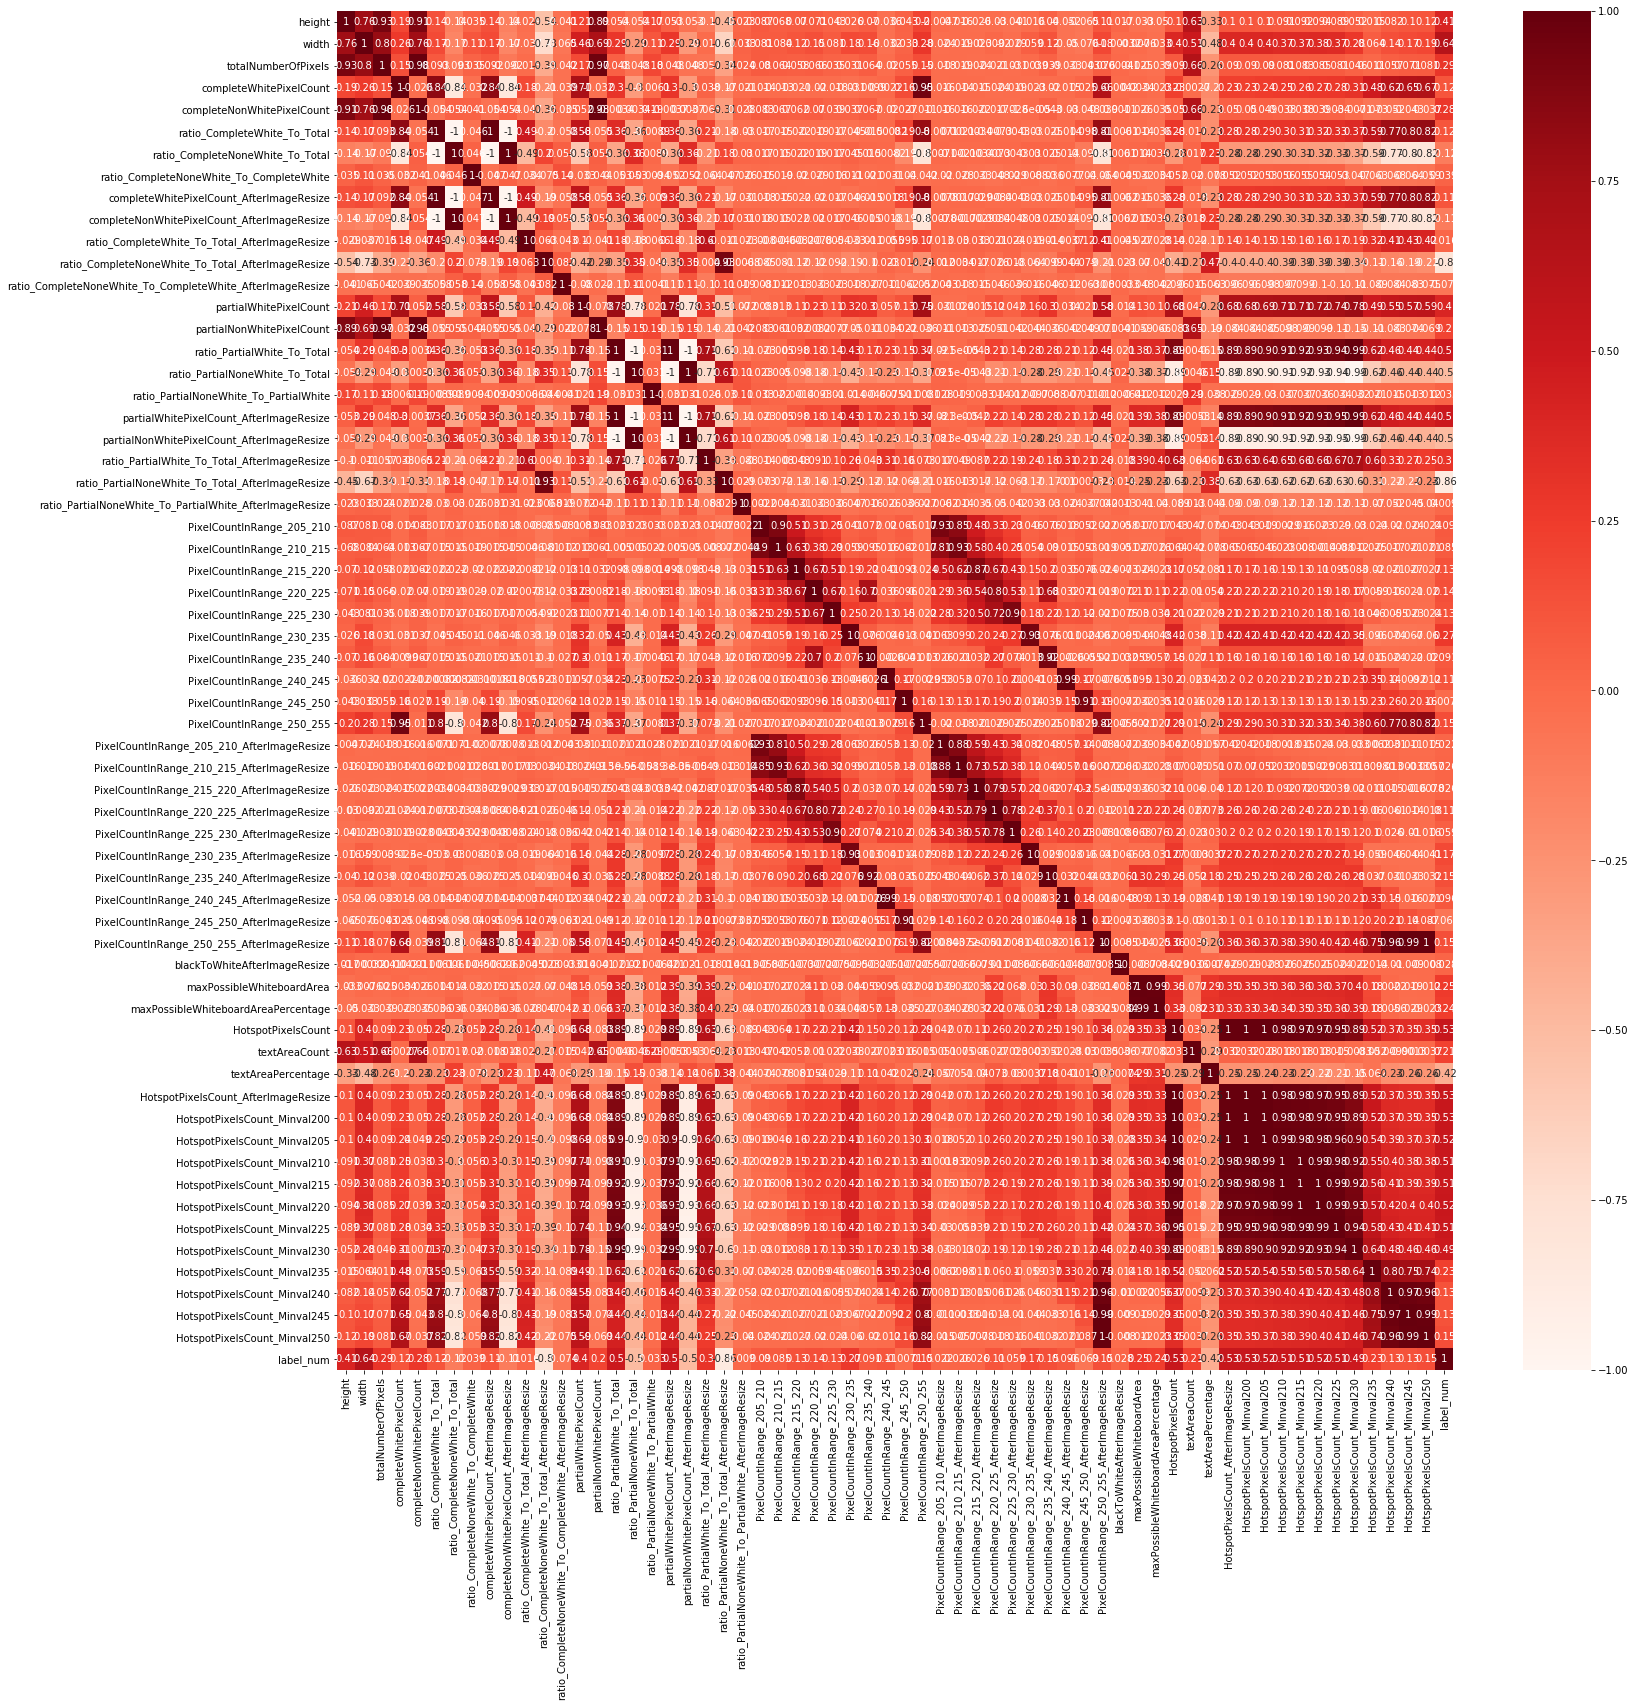

<Figure size 432x288 with 0 Axes>

In [0]:
#To find correlation using Pearson's correlation
import seaborn as sns
plt.figure(figsize=(25,25))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()
plt.savefig('correlation_new.png')
!cp 'correlation_new.png' "/content/gdrive/My Drive/"
